In [1]:
!wget "http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-complete.csv" --output-document "prices.csv"

--2020-04-21 13:28:44--  http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-complete.csv
Resolving prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com (prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com)... 52.218.36.52
Connecting to prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com (prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com)|52.218.36.52|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://prod1.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-complete.csv [following]
--2020-04-21 13:28:44--  http://prod1.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-complete.csv
Resolving prod1.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com (prod1.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com)... 52.218.97.180
Connecting to prod1.publicdata.landregistry.gov.uk

In [2]:
import pandas as pd
import requests 

pricingDataForever = pd.read_csv("prices.csv",header=None,usecols=[1,2,3], names=['Price','DateTime','PostCode'])
pricingDataForever.head()
# pricingDataForever = pricingDataForever[pricingDataForever['']] 
pricingDataForever['Dates'] = pd.to_datetime(pricingDataForever['DateTime']).dt.date
pricingDataForever['Time'] = pd.to_datetime(pricingDataForever['DateTime']).dt.time
pricingDataForever.head()

,Price,DateTime,PostCode,Dates,Time
0,42000,1995-12-21 00:00,NE4 9DN,1995-12-21,00:00:00
1,95000,1995-03-03 00:00,RM16 4UR,1995-03-03,00:00:00
2,74950,1995-10-03 00:00,CW10 9ES,1995-10-03,00:00:00
3,43500,1995-11-14 00:00,TS23 3LA,1995-11-14,00:00:00
4,63000,1995-09-08 00:00,CA25 5QH,1995-09-08,00:00:00


In [3]:
len(pricingDataForever)

25180684

In [0]:
pricingDataForever = pricingDataForever.dropna(subset=['PostCode'])

In [10]:
len(pricingDataForever)

25141801

# DO SOME DATA CLEANING ETC ETC


In [6]:
df = pricingDataForever[1:100]
df.head()

,Price,DateTime,PostCode,Dates,Time
1,95000,1995-03-03 00:00,RM16 4UR,1995-03-03,00:00:00
2,74950,1995-10-03 00:00,CW10 9ES,1995-10-03,00:00:00
3,43500,1995-11-14 00:00,TS23 3LA,1995-11-14,00:00:00
4,63000,1995-09-08 00:00,CA25 5QH,1995-09-08,00:00:00
5,29995,1995-05-12 00:00,PE14 8JF,1995-05-12,00:00:00


In [202]:
burnleyPricingData = pricingDataForever[pricingDataForever.apply(lambda x: x['PostCode'].strip().startswith('BB',0,2), axis=1)]
burnleyPricingData.head()

,Price,DateTime,PostCode,Dates,Time
217,32000,1995-12-15 00:00,BB3 2PB,1995-12-15,00:00:00
226,14000,1995-06-16 00:00,BB10 2HA,1995-06-16,00:00:00
466,73950,1995-09-06 00:00,BB10 3JW,1995-09-06,00:00:00
780,32000,1995-09-29 00:00,BB18 6NY,1995-09-29,00:00:00
849,90000,1995-08-18 00:00,BB12 8TR,1995-08-18,00:00:00


In [203]:
burnleyPricingData['Dates']

217         1995-12-15
226         1995-06-16
466         1995-09-06
780         1995-09-29
849         1995-08-18
               ...    
25171935    2020-01-17
25171938    2020-01-16
25171942    2020-01-22
25171943    2020-01-17
25171944    2020-01-10
Name: Dates, Length: 233892, dtype: object

In [0]:
burnleyPricingDataRecent = burnleyPricingData[burnleyPricingData.apply(lambda x: x['Dates'].year > 2010,axis=1)]

In [205]:
len(burnleyPricingDataRecent)

67946

In [0]:
import requests 
import json

postcodes = list(set(burnleyPricingDataRecent['PostCode'].values.tolist()))
url = 'http://api.postcodes.io/postcodes'
postcodeToLatLon = {}

for i in range(0,len(postcodes),100):
  myobj = {"postcodes" : postcodes[i:i+100]}
  res = requests.post(url, data = myobj)
  res = json.loads(res.text)
  for indivObj in res['result']:
    try:
      postcode = indivObj['query']
      postcodeToLatLon[postcode] = (indivObj['result']['latitude'],indivObj['result']['longitude'])
    except:
      postcodeToLatLon[postcode] = (0,0)

In [207]:
burnleyPricingDataRecent['LatLon'] = burnleyPricingDataRecent.apply(lambda x: postcodeToLatLon[x['PostCode'].strip()],axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [208]:
len(burnleyPricingDataRecent)

67946

In [209]:
burnleyPricingDataRecent = burnleyPricingDataRecent[burnleyPricingDataRecent['LatLon']!=(0,0)]
len(burnleyPricingDataRecent)

67858

In [210]:
burnleyPricingDataRecent['Lat'] = burnleyPricingDataRecent.apply(lambda x: '%.3f'%postcodeToLatLon[x['PostCode'].strip()][0],axis=1)
burnleyPricingDataRecent['Lon'] = burnleyPricingDataRecent.apply(lambda x: '%.3f'%postcodeToLatLon[x['PostCode'].strip()][1],axis=1)
burnleyPricingDataRecent.head()

,Price,DateTime,PostCode,Dates,Time,LatLon,Lat,Lon
16885774,217000,2011-04-15 00:00,BB18 5SX,2011-04-15,00:00:00,"(53.913586, -2.192254)",53.914,-2.192
16885869,75500,2011-06-06 00:00,BB1 6LP,2011-06-06,00:00:00,"(53.758154, -2.469987)",53.758,-2.470
16886030,250000,2011-09-29 00:00,BB2 7AH,2011-09-29,00:00:00,"(53.756808, -2.511272)",53.757,-2.511
16886042,100000,2011-04-28 00:00,BB1 8HH,2011-04-28,00:00:00,"(53.760946, -2.475434)",53.761,-2.475
16886331,168000,2011-03-08 00:00,BB4 8UN,2011-03-08,00:00:00,"(53.702023, -2.288654)",53.702,-2.289


In [211]:
from collections import defaultdict
mappingDict = defaultdict(list)

for index, row in burnleyPricingDataRecent.iterrows():
  mappingDict[(row['Lat'],row['Lon'])].append(row['Price'])

for key in mappingDict:
  mappingDict[key] = sum(mappingDict[key]) / len(mappingDict[key])

temp = pd.DataFrame(mappingDict.items())
temp.columns = ['LatLon','Price']
temp['Lat'] = temp.apply(lambda x: x['LatLon'][0],axis=1)
temp['Lon'] = temp.apply(lambda x: x['LatLon'][1],axis=1)
temp.head()



,LatLon,Price,Lat,Lon
0,"(53.914, -2.192)",219212.500000,53.914,-2.192
1,"(53.758, -2.470)",63888.888889,53.758,-2.470
2,"(53.757, -2.511)",312500.000000,53.757,-2.511
3,"(53.761, -2.475)",86288.461538,53.761,-2.475
4,"(53.702, -2.289)",139626.031579,53.702,-2.289


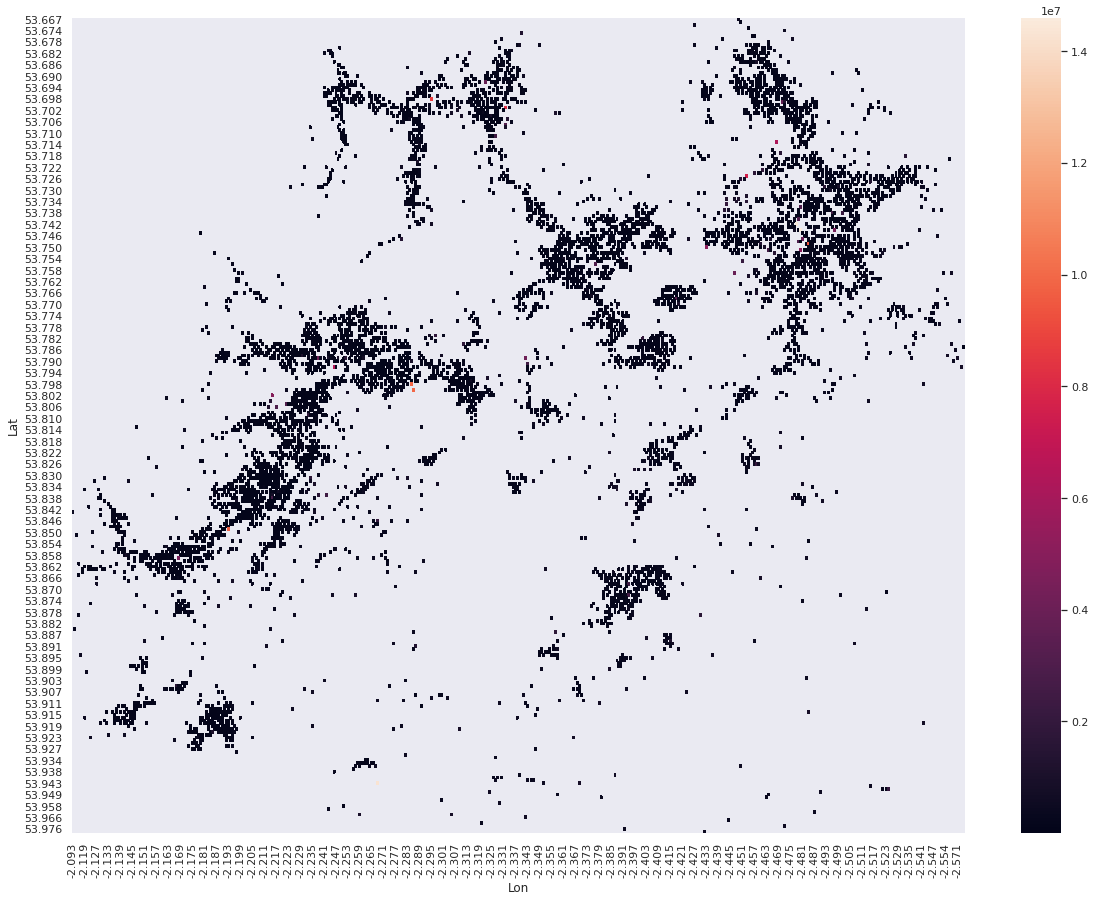

In [212]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20, 15]
flights = temp.pivot("Lat", "Lon", "Price")
ax = sns.heatmap(flights)

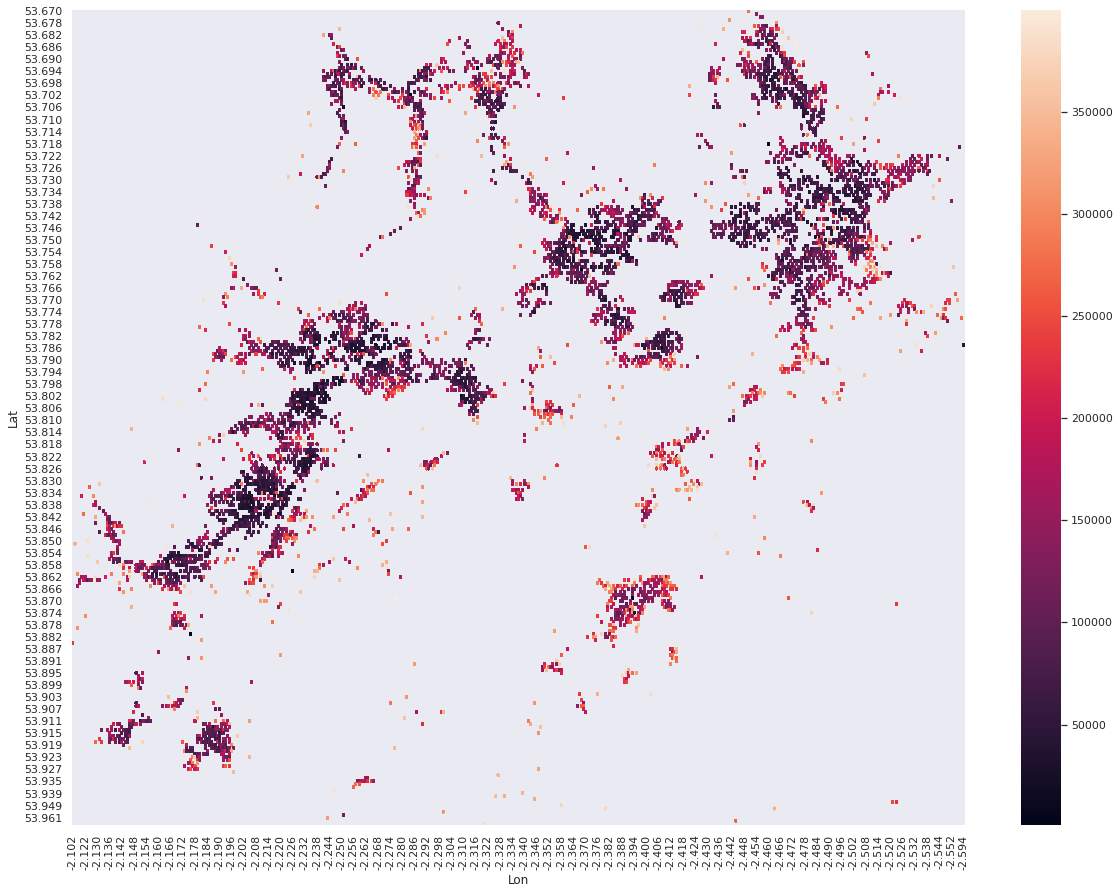

In [213]:
temp = temp[temp['Price']<400000]
flights = temp.pivot("Lat", "Lon", "Price")
ax = sns.heatmap(flights)

(271.0, 0.0) (0.0, 439.0)


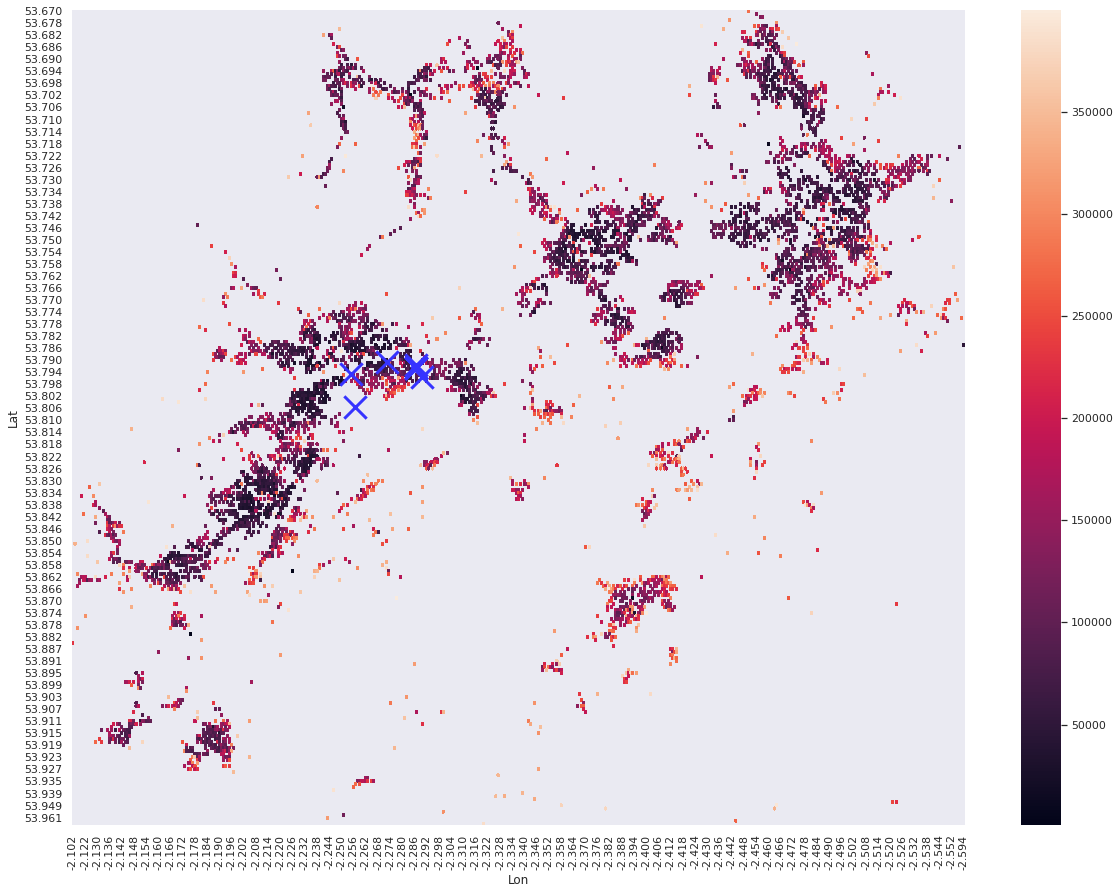

In [214]:
import pickle 
import matplotlib.pyplot as plt 

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

with open('chimneys','rb') as f:
  lst = pickle.load(f)

chimneys = lst[0]

fig, ax = plt.subplots(1,1)
ax = sns.heatmap(flights)
minLat = min(list(map(lambda x: float(x),temp['Lat'].values.tolist())))
maxLon = max(list(map(lambda x: float(x),temp['Lon'].values.tolist())))
print(ax.get_ylim(),ax.get_xlim())
for lat, lon in chimneys:
  newLat = float('%.3f'%lat)
  newLon = float('%.3f'%lon) 
  diffLat = int((newLat - minLat)*1000)
  diffLon = int((maxLon - newLon)*1000)
  ax.scatter(diffLon,diffLat, s=500, marker='x',c='#3633FF',linewidth=3)